In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import geopandas as gpd
import numpy as np
from shapely.geometry import box, Point
import matplotlib.pyplot as plt


In [ ]:
#load your shp file
boundary = gpd.read_file("/content/drive/MyDrive/Kerala covid 19 labs/Kerala_State.shp")#polygon
data = gpd.read_file("/content/drive/MyDrive/Kerala covid 19 labs/Covid19_Testing_Labs.shp") #polygon

In [ ]:
print('Boundary CRS:', boundary.crs)
print('Points CRS:', data.crs)

Boundary CRS: EPSG:32643
Points CRS: EPSG:4326


In [ ]:
data.isnull().sum()

,0
id,0
NAME,18
Address,0
District,0
Test Type,0
FullAddres,94
Lab Type,0
Latitude,0
Longitude,0
geometry,0


In [ ]:
#Remove rows with not needed
data = data.drop(columns=[])

In [ ]:
#Removes rows with any NAN values in any coulmn
df = data.dropna()
df.isnull().sum()

,0
id,0
NAME,0
Address,0
District,0
Test Type,0
FullAddres,0
Lab Type,0
Latitude,0
Longitude,0
geometry,0


In [ ]:
#Convert to Geodataframe
points = gpd.GeoDataFrame(df, geometry='geometry')

#Set Coordinate Reference System(CRS)
points.set_crs(epsg=4326, inplace=True) #WGS84

,id,NAME,Address,District,Test Type,FullAddres,Lab Type,Latitude,Longitude,geometry
2,1,Kinder Womens Hospital and Fertility Centre,Kinder Womens Hospital and Fertility Centre C...,Alappuzha,ANTIGEN,Kinder Womens Hospital and Fertility Centre C...,Private Lab,9.663174,76.341274,POINT (76.34127 9.66317)
6,2,Health Park Medical Centre,Health Park Medical Centre Alappuzha,Alappuzha,ANTIGEN,Health Park Medical Centre Alappuzha,Private Lab,9.491266,76.336663,POINT (76.33666 9.49127)
13,3,Sankar's Healthcare Scans & Diagnostics,Sankar's Healthcare Scans & Diagnostics Kanna...,Alappuzha,ANTIGEN,Sankar's Healthcare Scans & Diagnostics Kanna...,Private Lab,10.315467,76.330781,POINT (76.33078 10.31547)
18,4,Providence Hospital,Providence Hospital Thumpoly Alappuzha,Alappuzha,ANTIGEN,Providence Hospital Thumpoly Alappuzha Alap...,Private Lab,9.526216,76.327767,POINT (76.32777 9.52622)
21,5,Metro Diagnostic Centre,Metro Diagnostic Centre AVA Sona Tower Near G...,Alappuzha,ANTIGEN,Metro Diagnostic Centre AVA Sona Tower Near G...,Private Lab,9.452173,76.415145,POINT (76.41514 9.45217)
...,...,...,...,...,...,...,...,...,...,...
621,511,Metro Scans,Metro Scans Kailas Arcad District Hospital Ro...,Kollam,ANTIGEN,Metro Scans Kailas Arcad District Hospital Ro...,Private Lab,8.895683,76.600777,POINT (76.60078 8.89568)
622,513,Metro scans,Metro scans Bhavani Trade Centre. High School...,Kollam,ANTIGEN,Metro scans Bhavani Trade Centre. High School...,Private Lab,8.960836,76.914402,POINT (76.9144 8.96084)
623,514,Bio Lab Clinical laboratory,Bio Lab Clinical laboratory Modern Tower Man...,Kozhikode,ANTIGEN,Bio Lab Clinical laboratory Modern Tower Man...,Private Lab,11.332532,75.918834,POINT (75.91883 11.33253)
624,515,Western Hospital and Nursing Home,Western Hospital and Nursing Home Opp. Malaba...,Kozhikode,ANTIGEN,Western Hospital and Nursing Home Opp. Malaba...,Private Lab,11.557424,75.763633,POINT (75.76363 11.55742)


In [ ]:
points =points.to_crs(epsg=32643)
points.crs

<Projected CRS: EPSG:32643>
Name: WGS 84 / UTM zone 43N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°E and 78°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Maldives. Pakistan. Russian Federation. Tajikistan.
- bounds: (72.0, 0.0, 78.0, 84.0)
Coordinate Operation:
- name: UTM zone 43N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
#Calculate area of boundary polygon
Area = boundary.union_all().area
#compute grid cell size using the formula
n = len(points) # Assuming n is the number of points
cell_size = np.sqrt((2* Area)/n)

print(f"Calculated grid cell size:{cell_size:.2f} meters")
#Get bounds of boundary polygon
minx, miny, maxx, maxy = boundary.total_bounds

Calculated grid cell size:12111.05 meters


In [ ]:
#Create fishnet grid cells
cols = list(np.arange(minx, maxx + cell_size, cell_size))
rows = list(np.arange(miny, maxy + cell_size, cell_size))

grid_cells = []
for x in cols[:-1]:
  for y in rows[:-1]:
    cell = box(x,y,x + cell_size, y + cell_size)
    grid_cells.append(cell)

In [ ]:
# Convert to geodataframe
grid = gpd.GeoDataFrame({'geometry': grid_cells},crs=boundary.crs)
#clip grid to boundary
grid_clipped = gpd.overlay(grid, boundary, how='intersection')
#spatial join:assign points to grid cells
points_in_grid = gpd.sjoin(points,grid_clipped, predicate='within')
#count points per cell
point_counts = points_in_grid.groupby('index_right').size()
grid_clipped['point_count']= point_counts.reindex(grid_clipped.index).fillna(0)

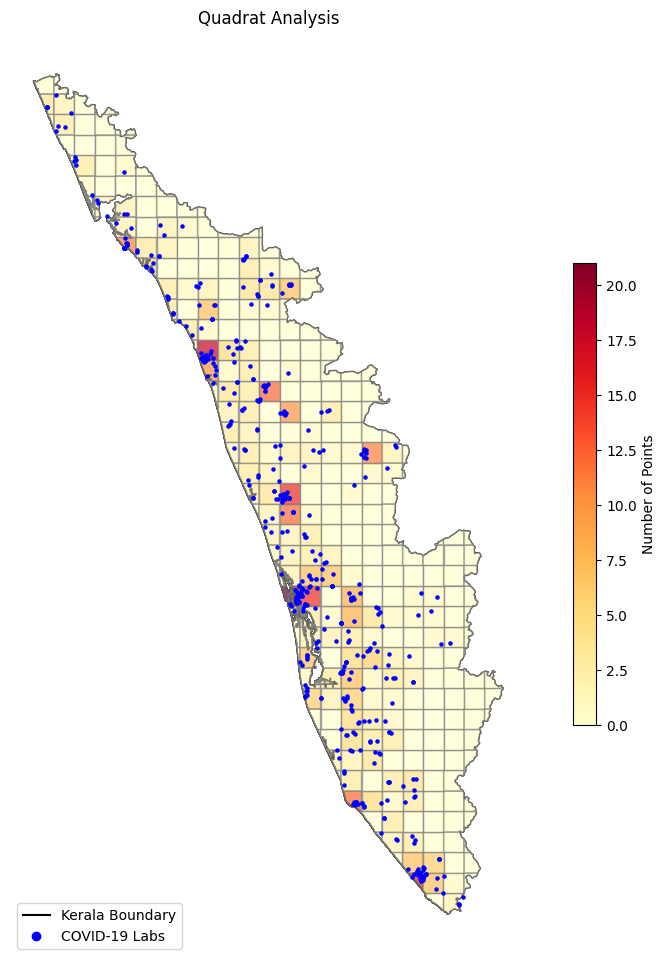

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot boundary
boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1, label='Kerala Boundary')

# Plot grid clipped with point counts
grid_clipped.plot(ax=ax, column='point_count', cmap='YlOrRd', edgecolor='gray', alpha=0.7, legend=True, legend_kwds={'label': "Number of Points", 'shrink': 0.5})

# Plot point data
points.plot(ax=ax, color='blue', markersize=5, label='COVID-19 Labs')

# Custom legend entries
boundary_line = mlines.Line2D([], [], color='black', label='Kerala Boundary')
point_patch = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=6, label='COVID-19 Labs')

# Add legend
plt.legend(handles=[boundary_line, point_patch], loc='lower left')

# Title and layout
plt.title("Quadrat Analysis")
plt.axis('off')
plt.show()


In [ ]:
# View first few rows
grid_clipped.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry,point_count
0,105,IND,India,18,Kerala,State,State,None,None,"POLYGON ((497623.32 1390121.398, 497623.32 138...",0.0
1,105,IND,India,18,Kerala,State,State,None,None,"POLYGON ((497623.32 1402232.451, 497623.32 139...",4.0
2,105,IND,India,18,Kerala,State,State,None,None,"POLYGON ((497623.32 1402232.451, 488855.866 14...",0.0
3,105,IND,India,18,Kerala,State,State,None,None,"MULTIPOLYGON (((509734.372 1365899.294, 509734...",1.0
4,105,IND,India,18,Kerala,State,State,None,None,"POLYGON ((509734.372 1378010.346, 509734.372 1...",0.0


/tmp/ipython-input-2952089898.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid_clipped.to_file("clipped_grid.shp")
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'point_count' to 'point_coun'
  ogr_write(


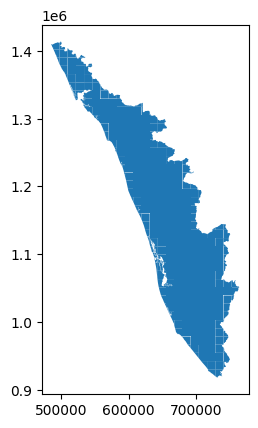

In [ ]:
# Plot
grid_clipped.plot()
#  Save to shapefile
grid_clipped.to_file("clipped_grid.shp")

In [ ]:
#extract the point counts per quadrat
counts = grid_clipped['point_count'].values

#calculate mean and variance
mean_count = counts.mean()
variance_count = counts.var(ddof=1)#simple variance

#Variance-to-Mean Ratio
vmr = variance_count / mean_count

print(f"Mean count per count quadrat:{mean_count}")
print(f"Variance of counts:{variance_count}")
print(f"Variance-to-Mean Ratio(VMR):{vmr}")

Mean count per count quadrat:1.532934131736527
Variance of counts:8.802215389041736
Variance-to-Mean Ratio(VMR):5.742070195195194


Repleys k Function & L_function

In [ ]:
!pip install pointpats


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.3 MB/s eta 0:00:00


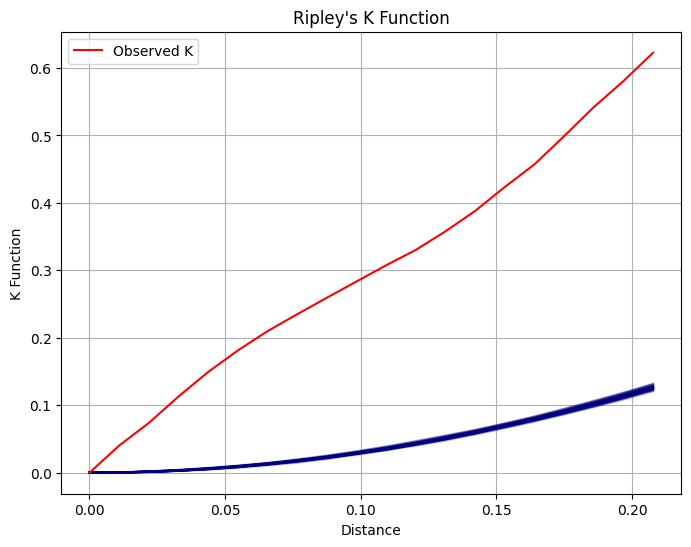

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pointpats

# Load your point shapefile
gdf = gpd.read_file('/content/drive/MyDrive/Kerala covid 19 labs/Covid19_Testing_Labs.shp')

# Extract x/y coordinates from geometries
gdf['centroid.x'] = gdf.geometry.x
gdf['centroid.y'] = gdf.geometry.y

# Stack into NumPy array
il_points = np.column_stack((gdf['centroid.x'], gdf['centroid.y']))

# K-function analysis
k_result = pointpats.k_test(il_points, n_simulations=99, keep_simulations=True)

# Plot simulations and observed K
plt.figure(figsize=(8,6))
plt.plot(k_result.support, k_result.simulations.T, color='navy', alpha=0.1)
plt.plot(k_result.support, k_result.statistic, color='red', label='Observed K')
plt.xlabel('Distance')
plt.ylabel('K Function')
plt.title("Ripley's K Function")
plt.grid(True)
plt.legend()
plt.show()


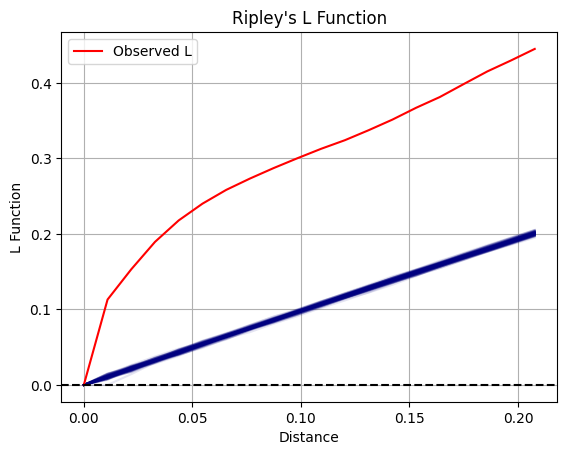

In [ ]:
# L-function test
l_test = pointpats.l_test(il_points, n_simulations=99, keep_simulations=True)

# Plotting
plt.plot(l_test.support, l_test.simulations.T, color='navy', alpha=0.1)
plt.plot(l_test.support, l_test.statistic, color='red', label='Observed L')
plt.xlabel('Distance')
plt.ylabel('L Function')
plt.title("Ripley's L Function")
plt.axhline(0, color='black', linestyle='--')  # Optional: zero line for reference
plt.legend()
plt.grid(True)
plt.show()
